In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.layers import Input, Reshape, concatenate, Dense, Dropout, Lambda, Flatten, Activation, LeakyReLU, Conv2D, UpSampling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal, glorot_normal
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import csv
import math

def load_mnist():
    # 学習データ
    x_train = np.load('/root/userspace/public/lesson6/data/x_train.npy')
    y_train = np.load('/root/userspace/lesson6/data/km_labels.npy')

    # -1 ~ 1 に正規化
    #x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255
    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')
    x_train = (x_train-127.5)/127.5
    
    return x_train, y_train
x_train, y_train = load_mnist()
generated_image_num = 50
STEP = 30000 #訓練ステップ数
BATCH_SIZE = 128

In [2]:
# ラベルごとのデータ数を均等にしてみる
labels, ucounts = np.unique(y_train, return_counts=True)
min_count = np.min(ucounts)
use_indexes = []
for label in labels:
    label_indexes = np.where(y_train==label)[0]
    #print(label_indexes.shape)
    use_indexes += np.random.choice(label_indexes, min_count, replace=False).tolist()
    print(len(use_indexes))
x_train = x_train[np.array(use_indexes)]
y_train = y_train[np.array(use_indexes)]

2731
5462
8193
10924
13655
16386
19117
21848
24579
27310


In [3]:
# ohehotエンコーディング
y_train = to_categorical(y_train)

In [4]:
# class=1 ラベルを [0.7, 1.2] にスムージング
def smooth_positive_labels(y):
    return y - 0.3 + (np.random.random(y.shape) * 0.5)

# class=0 ラベルを [0, 0.3] にスムージング
def smooth_negative_labels(y):
    return y + np.random.random(y.shape) * 0.3

# p_flip の確率でラベルの 0,1 を入れ替える
def noisy_labels(y, p_flip):
    # determine the number of labels to flip
    n_select = int(p_flip * y.shape[0])
    # choose labels to flip
    flip_ix = np.random.choice([i for i in range(y.shape[0])], size=n_select)
    # invert the labels in place
    y[flip_ix] = abs(1 - y[flip_ix]) #負の値が出ないように絶対値を取る。いいかどうかわからん
    return y

def Generator():
    nch=200
    model_input = Input(shape=[100])
    cond = Input(shape=[10])
    cond_input = concatenate([model_input, cond], axis=-1)

    init = RandomNormal(mean=0.0, stddev=0.01) #ガウス分布で初期化
    #init = glorot_normal()
    x = Dense(nch*14*14, kernel_initializer=init)(model_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Reshape( [14, 14, nch] )(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(int(nch/2), (3, 3), padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(int(nch/4), (3, 3), padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(1, (1, 1), padding='same', kernel_initializer=init)(x)
    #model_output = Activation('sigmoid')(x)
    model_output = Activation('tanh')(x)
    model = Model([model_input, cond], model_output)

    return model

def Discriminator(shape, dropout_rate=0.25, opt=Adam(lr=1e-5, beta_1=0.1)):
    # memo: lr 1e-4->1e-5 beta_1 0.5->0.1 に小さくする
    model_input = Input(shape=shape)
    cond = Input(shape=[10])
    init = RandomNormal(mean=0.0, stddev=0.02) # ガウス分布で重み初期化

    cond_reshape = Reshape([1,1,10])(cond)
    cond_reshape = Lambda(lambda x: K.ones([28, 28, 10])*x)(cond_reshape)
    cond_input = concatenate([model_input, cond_reshape], axis=-1)

    #init = glorot_normal()
    x = Conv2D(256, (5, 5), padding = 'same', kernel_initializer=init, strides=(2, 2))(model_input)
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(512, (5, 5), padding = 'same', kernel_initializer=init, strides=(2, 2))(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    x = Flatten()(x)
    x = Dense(256)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    #model_output = Dense(2,activation='softmax')(x)
    model_output = Dense(1,activation='sigmoid')(x)
    model = Model([model_input, cond], model_output)
    #model.compile(loss='categorical_crossentropy', optimizer=opt)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

def combined_network(generator, discriminator, opt=Adam(lr=1e-3, beta_1=0.5)):
    gan_input = Input(shape=[100])
    cond = Input(shape=[10])

    x = generator([gan_input, cond])
    gan_output = discriminator([x, cond])
    model = Model([gan_input, cond], gan_output)
    #model.compile(loss='categorical_crossentropy', optimizer=opt)
    model.compile(loss='binary_crossentropy', optimizer=opt)

    return model

def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val
        
def plot_loss(g_loss, d_loss):
    fig, ax = plt.subplots(1,1, figsize=(15, 5))
    epochs=range(1, len(g_loss)+1)    
    
    ax.plot(epochs, g_loss, label='G')
    ax.plot(epochs, d_loss, label='D')
    ax.legend()
    ax.set_title('Loss')
    plt.show()
    
def decay_noise(e):
    noise=0.05
    if e>5000:
        noise=0.02
    elif e>7000:
        noise=0.01
    return noise

def train(step=10000, BATCH_SIZE=128, plot_step=1000, save_step=1000):
#     g_tensorboard, d_tensorboard = tensorboards()
#     g_tensorboard.set_model(GAN)
#     d_tensorboard.set_model(discriminator)
    g_loss = []
    d_loss = []
    for e in tqdm(range(step)):
        image_indexes = np.random.randint(0,x_train.shape[0],size=BATCH_SIZE)
        image_batch = x_train[image_indexes,:,:,:]
        label_batch = y_train[image_indexes]
        #noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        noise_gen = np.random.randn(BATCH_SIZE,100) #ガウス分布でサンプリング
        generated_images = generator.predict([noise_gen, label_batch])
        
        # [TODO]inception score 計算
#         score = calculate_inception_score(generated_images)
#         if e > 1000 and score > max_score:
#             max_score = score
#             print(f"epoch{e}: max score: {score}")
#             # Save the model
#             generator.save('/root/userspace/generator.h5')
#             discriminator.save('/root/userspace/discriminator.h5')
#             GAN.save('/root/userspace/GAN.h5')            
            

        #----------------- Discriminator の訓練 -----------------
        make_trainable(discriminator,True)

#         X = np.concatenate((image_batch, generated_images))
#         y = np.zeros([2*BATCH_SIZE,2])
#         y[:BATCH_SIZE,1] = 1
#         y[BATCH_SIZE:,0] = 1

        
        # separate real/fake batch with label smoothing and noisy label
        # 1: train real labels
        y = np.zeros([BATCH_SIZE,1])
        y[:BATCH_SIZE,0] = 1
        y = smooth_positive_labels(y)
        y = noisy_labels(y, decay_noise(e))
        discriminator.train_on_batch([image_batch, label_batch], y)

        # 2: train fake labels
        y = np.zeros([BATCH_SIZE,1])
        y[:BATCH_SIZE,0] = 0
        y = smooth_negative_labels(y)
        #y = noisy_labels(y, decay_noise(e))
        d_logs = discriminator.train_on_batch([generated_images, label_batch], y)

        #d_logs = discriminator.train_on_batch(X,y)
        # d_tensorboard.on_epoch_end(e, named_logs(discriminator, d_logs))
        d_loss.append(d_logs)

        #----------------- Genarator の訓練 -----------------
        make_trainable(discriminator,False)

        #noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        noise_gen = np.random.randn(BATCH_SIZE,100) #ガウス分布でサンプリング
        #y2 = np.zeros([BATCH_SIZE,2])
        #y2[:,1] = 1
        y2 = np.zeros([BATCH_SIZE,1])
        y2[:,0] = 1

        label_batch2 = np.random.randint(0,10,size=BATCH_SIZE)
        label_batch2 = np.eye(10)[label_batch2]
        g_logs = GAN.train_on_batch([noise_gen, label_batch2], y2)
        # g_tensorboard.on_batch_end(e, named_logs(GAN, g_logs))
        g_loss.append(g_logs)
        
        if e % plot_step == 0 and e > 5000:
            # 画像確認, csv保存
            plot_mnist_conditional(generator)
            path= f'/root/userspace/step{e}_submission.csv'
            output_csv(path, generated_image_num)
            print(f"d_loss: {d_logs}  g_loss: {g_logs}")
            
        if e % save_step == 0:
            generator.save(f'/root/userspace/generator_step{e}.h5')
            
    #g_tensorboard.on_train_end(None)
    #d_tensorboard.on_train_end(None)
    plot_loss(g_loss, d_loss)
        
def plot_mnist_conditional(generator, n_ex=10,dim=(2, 5), figsize=(8,4), labels=range(10)):
    #noise = np.random.uniform(0,1,size=[n_ex,100])
    noise = np.random.randn(n_ex,100)
    label_batch = np.eye(10)[np.arange(10)]
    #l = np.eye(10)[np.arange(10)]
    generated_images = generator.predict([noise, label_batch])

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1], i+1)
        img = generated_images[i,:,:, 0]
        plt.imshow(img, cmap='binary')
        plt.title(labels[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
def tensorboards():
    g_logdir = "/root/userspace/logs/gen"
    g_tensorboard = TensorBoard(
      log_dir=g_logdir,
      histogram_freq=0,
      batch_size=BATCH_SIZE,
      write_graph=True,
      write_grads=True
    )
    d_logdir = "/root/userspace/logs/disc"
    d_tensorboard = TensorBoard(
      log_dir=d_logdir,
      histogram_freq=0,
      batch_size=BATCH_SIZE,
      write_graph=True,
      write_grads=True
    )
    print(f'g_logdir:{g_logdir}')
    print(f'd_logdir:{d_logdir}')
    return g_tensorboard, d_tensorboard


# Transform train_on_batch return value
# to dict expected by on_batch_end callback
def named_logs(model, logs):
    result = {}
    for l in zip(model.metrics_names, [logs]):
        result[l[0]] = l[1]
    return result


def output_csv(path, generated_image_num):
    #noise = np.random.uniform(0,1,size=[generated_image_num,100])
    noise = np.random.randn(generated_image_num,100)
    l = np.eye(10)[np.arange(10)]
    labels = np.vstack([l,l,l,l,l]) #50ラベル分
    generated_images = generator.predict([noise, labels])
    with open(path, 'w') as file:
        writer = csv.writer(file, lineterminator='\n')
        writer.writerows(generated_images.reshape(-1, 28*28).tolist())

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


  0%|          | 0/30000 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


 20%|██        | 6000/30000 [33:45<2:12:07,  3.03it/s]

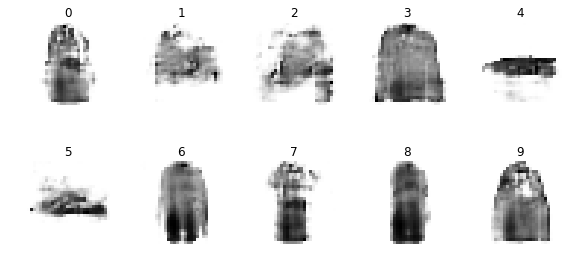

 20%|██        | 6001/30000 [33:46<3:45:08,  1.78it/s]

d_loss: 0.630365252494812  g_loss: 0.820727527141571


 23%|██▎       | 7000/30000 [39:16<2:06:21,  3.03it/s]

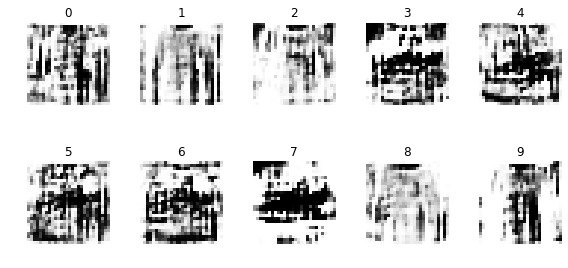

 23%|██▎       | 7001/30000 [39:17<3:25:38,  1.86it/s]

d_loss: 0.47091689705848694  g_loss: 0.0722905844449997


 27%|██▋       | 8000/30000 [44:47<2:00:59,  3.03it/s]

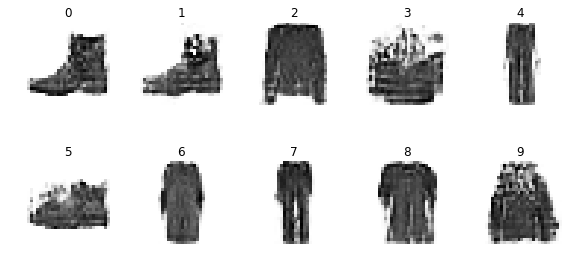

 27%|██▋       | 8001/30000 [44:48<3:28:28,  1.76it/s]

d_loss: 0.79280686378479  g_loss: 0.634258508682251


 30%|███       | 9000/30000 [50:17<1:55:16,  3.04it/s]

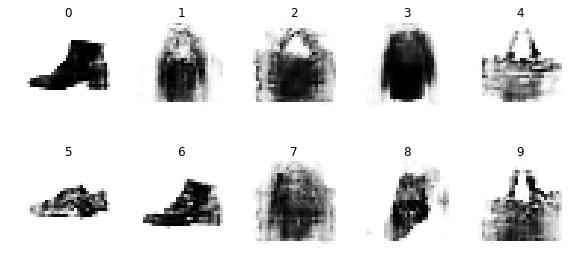

 30%|███       | 9001/30000 [50:18<3:06:42,  1.87it/s]

d_loss: 0.7121685743331909  g_loss: 0.7032766342163086


 33%|███▎      | 10000/30000 [55:48<1:50:02,  3.03it/s]

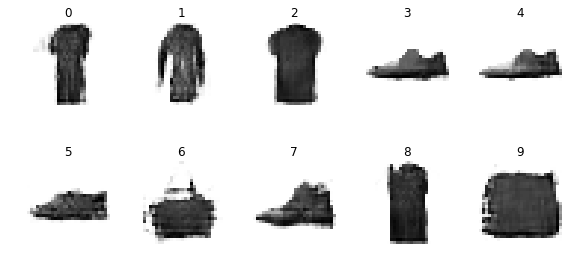

d_loss: 0.7986429929733276  g_loss: 0.6187521815299988


 37%|███▋      | 11000/30000 [1:01:19<1:44:25,  3.03it/s]

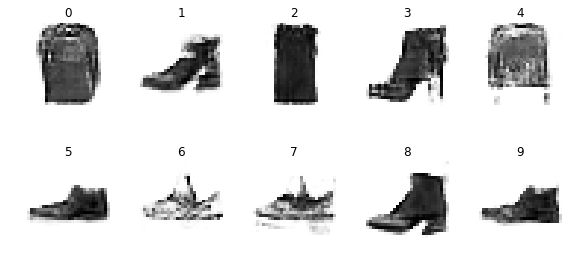

 37%|███▋      | 11001/30000 [1:01:20<2:48:30,  1.88it/s]

d_loss: 0.7810078859329224  g_loss: 0.6106253862380981


 40%|████      | 12000/30000 [1:06:50<1:38:46,  3.04it/s]

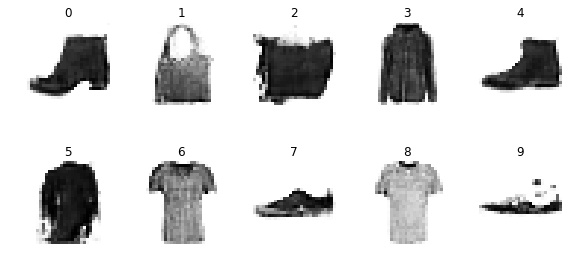

 40%|████      | 12001/30000 [1:06:51<2:50:16,  1.76it/s]

d_loss: 0.7738686203956604  g_loss: 0.6236254572868347


 43%|████▎     | 13000/30000 [1:12:20<1:33:11,  3.04it/s]

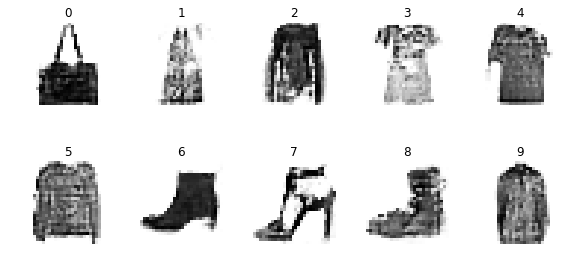

 43%|████▎     | 13001/30000 [1:12:21<2:26:17,  1.94it/s]

d_loss: 0.7629126310348511  g_loss: 0.6205052137374878


 47%|████▋     | 14000/30000 [1:17:51<1:28:06,  3.03it/s]

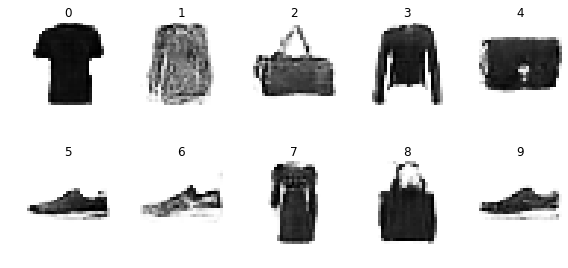

 47%|████▋     | 14001/30000 [1:17:52<2:28:40,  1.79it/s]

d_loss: 0.7628278136253357  g_loss: 0.6172734498977661


 50%|█████     | 15000/30000 [1:23:22<1:22:34,  3.03it/s]

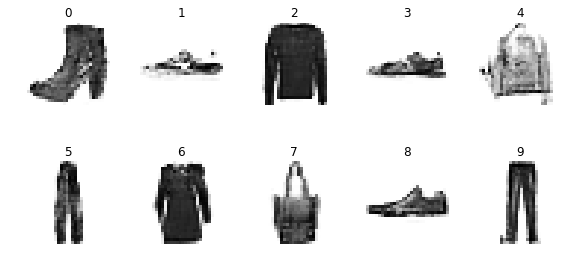

d_loss: 0.7545933723449707  g_loss: 0.6213990449905396


 53%|█████▎    | 16000/30000 [1:28:52<1:16:58,  3.03it/s]

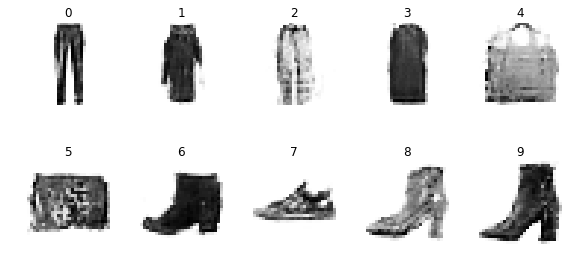

 53%|█████▎    | 16001/30000 [1:28:53<2:04:50,  1.87it/s]

d_loss: 0.7604939341545105  g_loss: 0.6157901287078857


 57%|█████▋    | 17000/30000 [1:34:23<1:11:36,  3.03it/s]

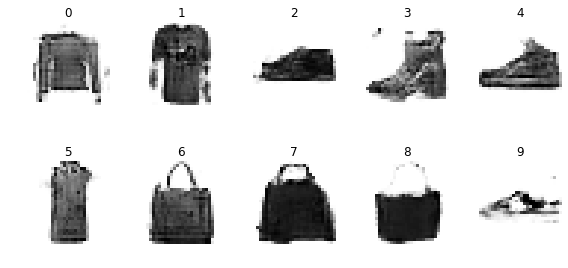

 57%|█████▋    | 17001/30000 [1:34:24<1:54:55,  1.89it/s]

d_loss: 0.7603574991226196  g_loss: 0.6097943186759949


 60%|██████    | 18000/30000 [1:39:54<1:05:58,  3.03it/s]

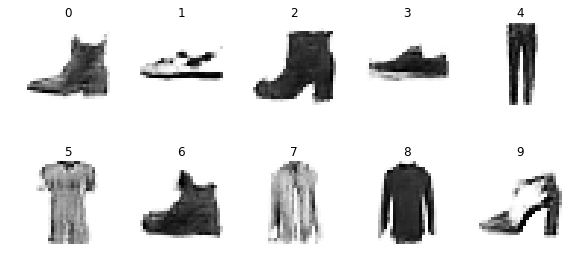

 60%|██████    | 18001/30000 [1:39:55<1:45:31,  1.90it/s]

d_loss: 0.7554466128349304  g_loss: 0.6113582253456116


 63%|██████▎   | 19000/30000 [1:45:24<1:00:30,  3.03it/s]

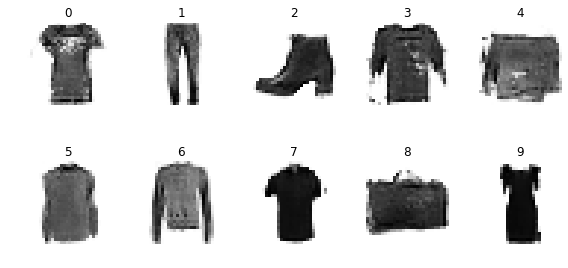

 63%|██████▎   | 19001/30000 [1:45:25<1:38:42,  1.86it/s]

d_loss: 0.753682017326355  g_loss: 0.6161747574806213


 67%|██████▋   | 20000/30000 [1:50:55<54:52,  3.04it/s]  

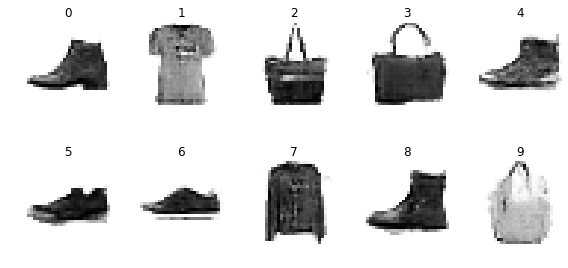

d_loss: 0.7586016654968262  g_loss: 0.6096634268760681


 70%|███████   | 21000/30000 [1:56:26<49:30,  3.03it/s]  

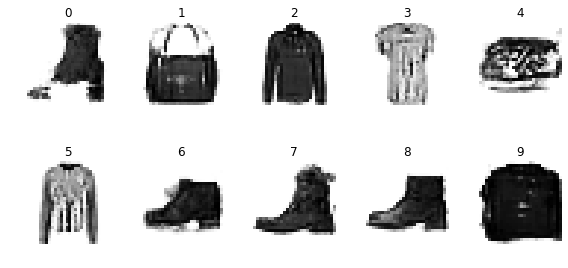

 70%|███████   | 21001/30000 [1:56:27<1:20:39,  1.86it/s]

d_loss: 0.7598739862442017  g_loss: 0.6195098757743835


 73%|███████▎  | 22000/30000 [2:01:57<43:59,  3.03it/s]  

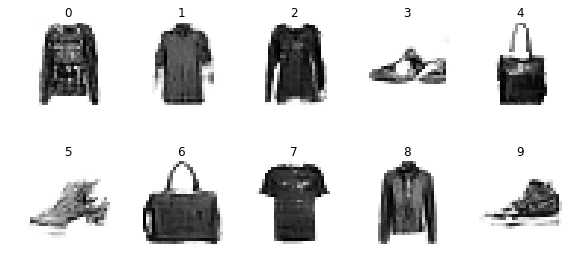

 73%|███████▎  | 22001/30000 [2:01:58<1:14:35,  1.79it/s]

d_loss: 0.7553626894950867  g_loss: 0.6239051818847656


 77%|███████▋  | 23000/30000 [2:07:27<38:13,  3.05it/s]  

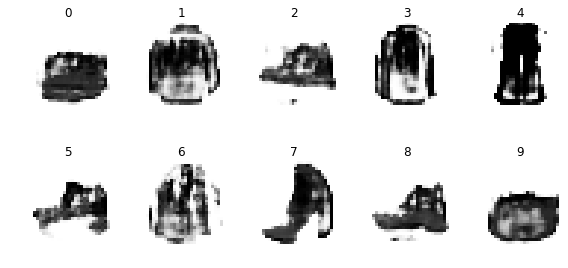

 77%|███████▋  | 23001/30000 [2:07:28<1:01:12,  1.91it/s]

d_loss: 0.6516327857971191  g_loss: 0.43193548917770386


 80%|████████  | 24000/30000 [2:12:58<32:58,  3.03it/s]  

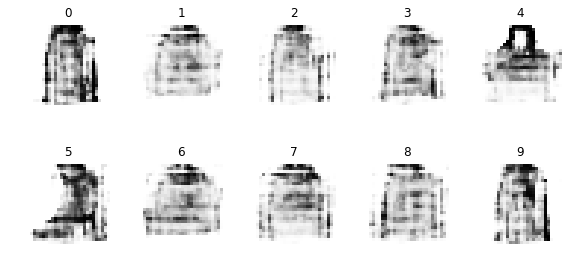

 80%|████████  | 24001/30000 [2:12:59<52:41,  1.90it/s]

d_loss: 0.4946201741695404  g_loss: 0.15311852097511292


 83%|████████▎ | 25000/30000 [2:18:28<27:29,  3.03it/s]

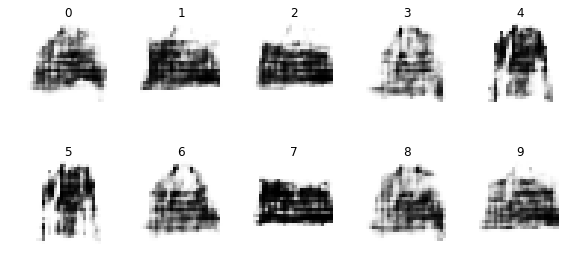

d_loss: 0.45648860931396484  g_loss: 0.223440483212471


 87%|████████▋ | 26000/30000 [2:23:59<21:58,  3.03it/s]

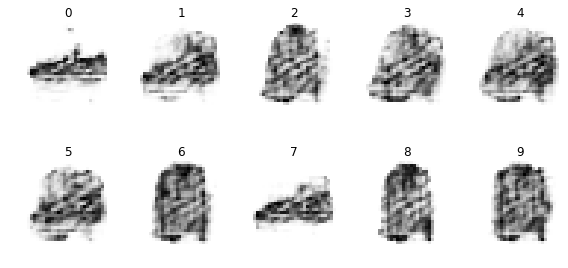

 87%|████████▋ | 26001/30000 [2:24:00<35:22,  1.88it/s]

d_loss: 0.5068559646606445  g_loss: 0.3169907331466675


 90%|█████████ | 27000/30000 [2:29:30<16:30,  3.03it/s]

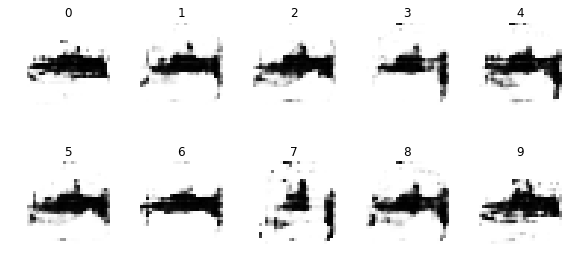

 90%|█████████ | 27001/30000 [2:29:31<26:52,  1.86it/s]

d_loss: 0.5035191774368286  g_loss: 1.1704444885253906


 93%|█████████▎| 28000/30000 [2:35:00<11:01,  3.02it/s]

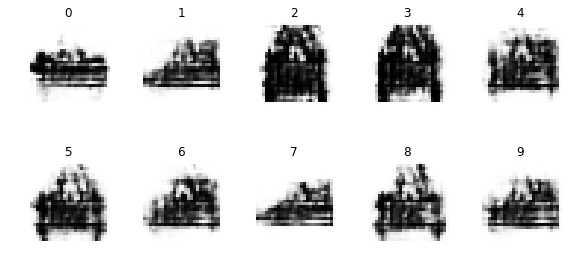

 93%|█████████▎| 28001/30000 [2:35:02<17:58,  1.85it/s]

d_loss: 0.5259649157524109  g_loss: 0.6011279225349426


 97%|█████████▋| 29000/30000 [2:40:31<05:29,  3.03it/s]

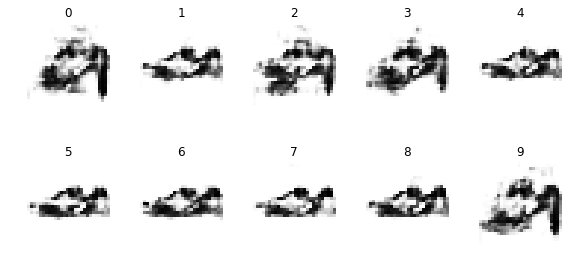

 97%|█████████▋| 29001/30000 [2:40:32<08:51,  1.88it/s]

d_loss: 0.42469048500061035  g_loss: 0.1343403160572052


100%|██████████| 30000/30000 [2:46:02<00:00,  3.01it/s]


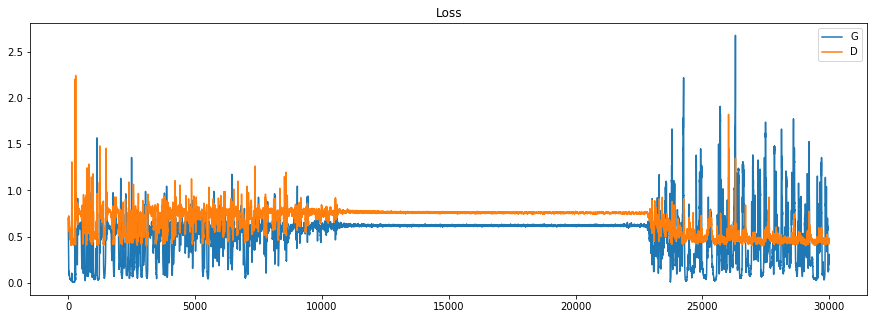

In [5]:
generator = Generator()
discriminator = Discriminator(x_train.shape[1:])
make_trainable(discriminator, False)
GAN = combined_network(generator, discriminator)

train(step=STEP, BATCH_SIZE=BATCH_SIZE, plot_step=1000, save_step=5000)

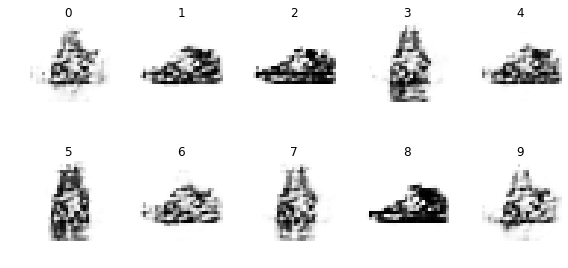

In [6]:
plot_mnist_conditional(generator)

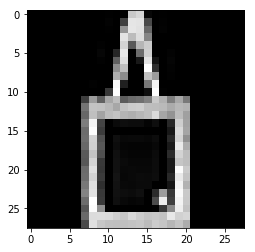

In [7]:
plt.imshow(x_train[5, :,:, 0], cmap='gray')

In [8]:
# Save the model
generator.save('/root/userspace/generator.h5')
discriminator.save('/root/userspace/discriminator.h5')
GAN.save('/root/userspace/GAN.h5')

In [14]:
#generator = load_model('/root/userspace/generator_step20000.h5')
generator = load_model('/root/userspace/generator.h5')

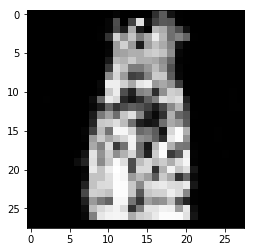

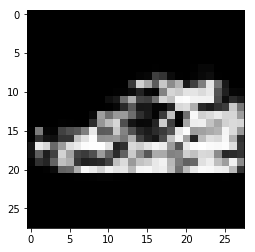

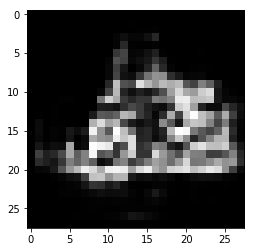

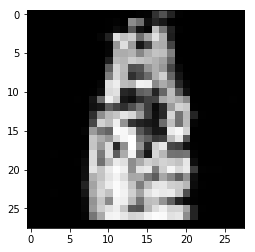

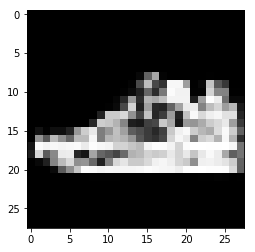

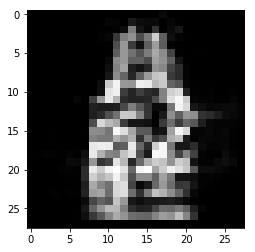

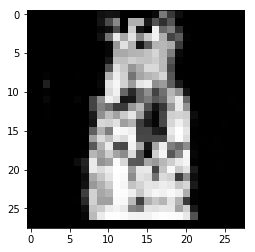

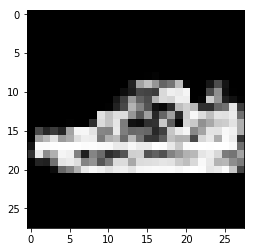

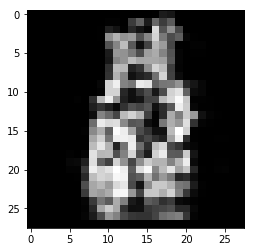

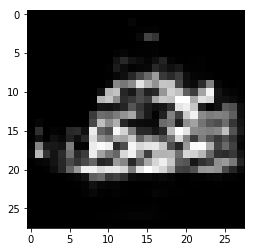

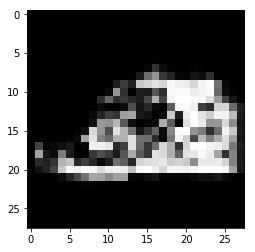

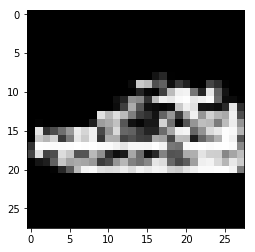

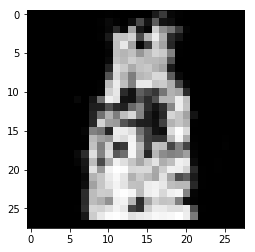

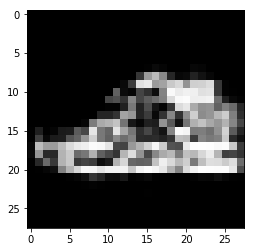

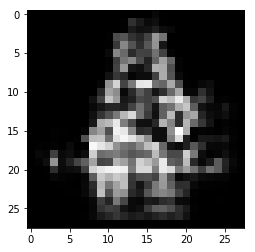

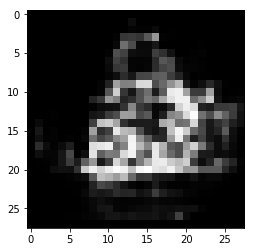

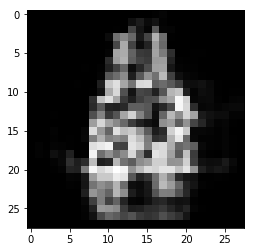

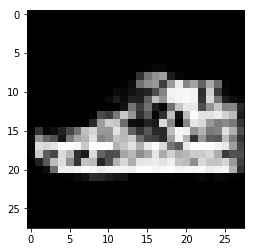

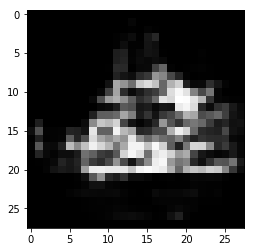

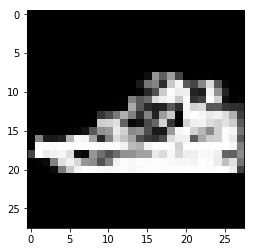

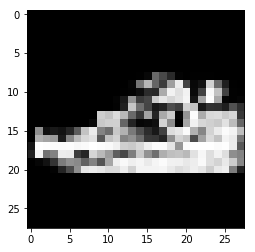

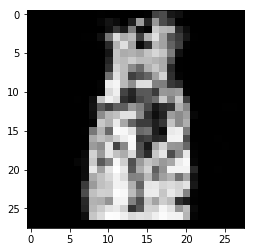

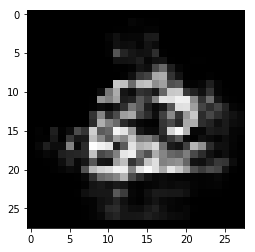

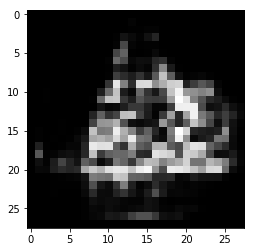

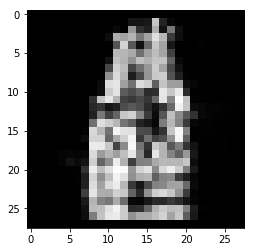

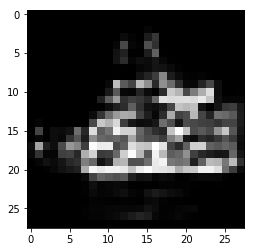

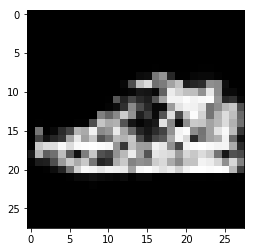

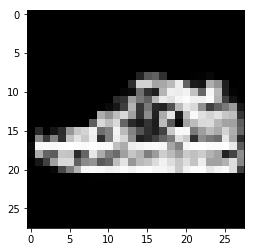

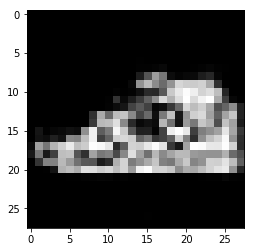

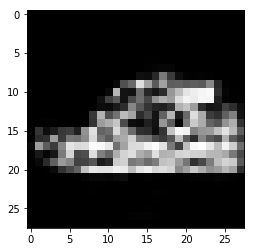

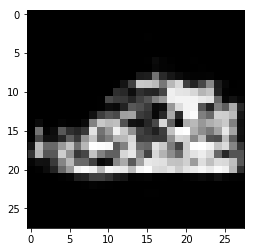

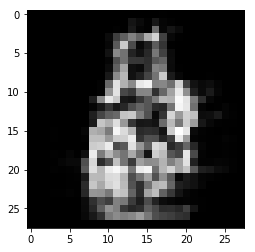

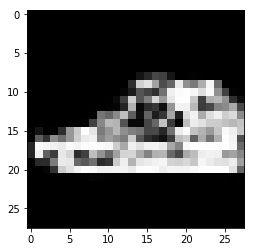

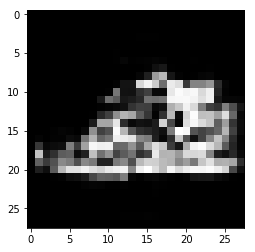

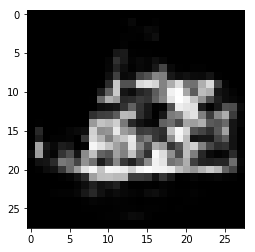

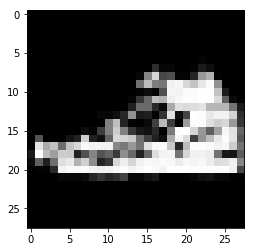

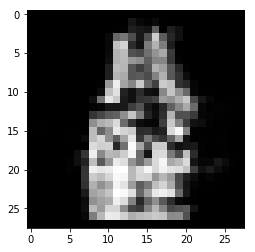

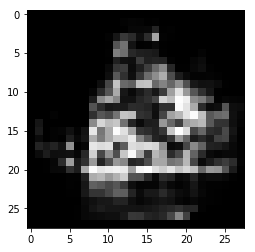

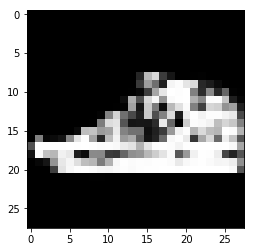

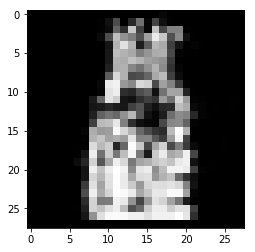

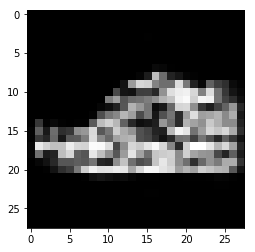

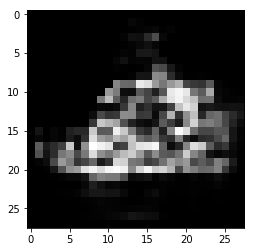

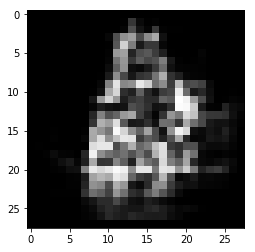

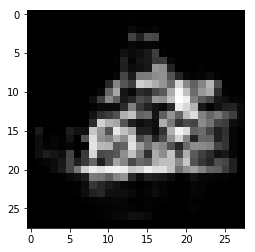

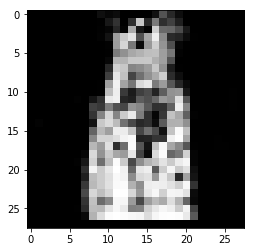

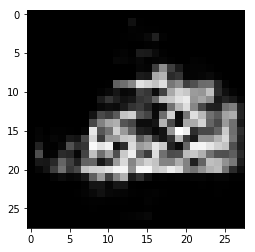

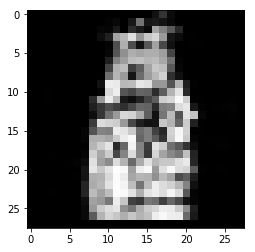

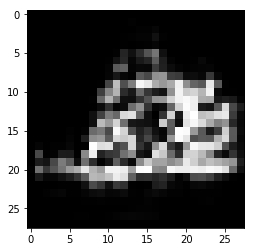

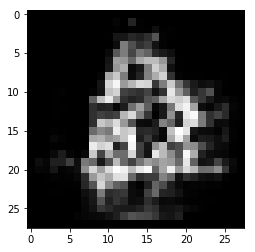

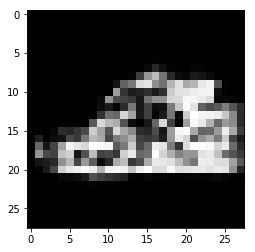

In [15]:
noise = np.random.randn(generated_image_num,100)
l = np.eye(10)[np.arange(10)]
labels = np.vstack([l,l,l,l,l]) #50ラベル分
generated_images = generator.predict([noise, labels])
for img in generated_images:
    plt.imshow(img[:,:,0], cmap='gray')
    plt.show()

In [11]:
path='/root/userspace/kmDCGAN_bl_submission10000.csv'
with open(path, 'w') as file:
    writer = csv.writer(file, lineterminator='\n')
    writer.writerows(generated_images.reshape(-1, 28*28).tolist())